# TensorFlow Classification Example
### Key Elements
- `tf.estimator`


- `tf.feature_column`
    - `tf.feature_column.numeric_column()`
    - `tf.feature_column.categorical_column_with_vocabulary_list()`
    - `tf.feature_column.bucketized_column()`
    - `tf.feature_column.embedding_column()`


- `tf.estimator.inputs`
    - `tf.estimator.inputs.pandas_input_fn()`
    - `tf.estimator.inputs.numpy_input_fn()`
    

### `tf.estimator` API workflow:
- **Normalize** continuous numeric features


- Create **feature column objets**, numeric columns and categorical columns are different


- If there is a continuous column you want to make categorical, use `tf.feature_column.bucktized_column()`


- Create list of feature columns (a list of `tf.feature_column` objects)


- Train test split with `sklearn.model_selection.train_test_split()`


- Create **input functions**, to connect pandas/numpy with feature_columns
    - Choose `batch_size`, `num_epochs`, `shuffle` parameters when defining input functions


- Create **classifier object**, e.g. `tf.estimator.LinearClassifier()`


- `model.train()`


- Evaluate
    - Create input function for evaluate data sets, e.g. `eval_input_func = tf.estimator.inputs.pandas_input_fn(...)`
    - `model.evaluate(eval_input_func)`


- Predict
    - Create input function for data sets to predict on, e.g. `pred_input_func = tf.estimator.inputs.pandas_input_fn(...)`
    - `model.predict(pred_input_func)`

### Import and clean `diabetes` dataset

In [1]:
import pandas as pd
diabetes = pd.read_csv('../../02-TensorFlow-Basics/pima-indians-diabetes.csv')

In [2]:
diabetes.head()

,Number_pregnant,Glucose_concentration,Blood_pressure,Triceps,Insulin,BMI,Pedigree,Age,Class,Group
0,6,0.743719,0.590164,0.353535,0.000000,0.500745,0.234415,50,1,B
1,1,0.427136,0.540984,0.292929,0.000000,0.396423,0.116567,31,0,C
2,8,0.919598,0.524590,0.000000,0.000000,0.347243,0.253629,32,1,B
3,1,0.447236,0.540984,0.232323,0.111111,0.418778,0.038002,21,0,B
4,0,0.688442,0.327869,0.353535,0.198582,0.642325,0.943638,33,1,C


Note: the `Group` column is a meaningless column added by Jose. It's put here just to demonstrate how to deal with categorical features.

In [3]:
print(diabetes.columns)

Index(['Number_pregnant', 'Glucose_concentration', 'Blood_pressure', 'Triceps',
       'Insulin', 'BMI', 'Pedigree', 'Age', 'Class', 'Group'],
      dtype='object')


In [4]:
cols_to_norm = ['Number_pregnant', 'Glucose_concentration', 'Blood_pressure', 'Triceps', 'Insulin', 'BMI', 'Pedigree']
# from sklearn.preprocessing import MinMaxScaler
# diabetes[cols_to_norm] = diabetes[cols_to_norm].apply(lambda col: MinMaxScaler().fit_transform(col.values.reshape(-1,1)).flatten(), axis=0)
diabetes[cols_to_norm] = diabetes[cols_to_norm].apply(lambda col: (col-col.min())/(col.max()-col.min()))
diabetes.head()

,Number_pregnant,Glucose_concentration,Blood_pressure,Triceps,Insulin,BMI,Pedigree,Age,Class,Group
0,0.352941,0.743719,0.590164,0.353535,0.000000,0.500745,0.234415,50,1,B
1,0.058824,0.427136,0.540984,0.292929,0.000000,0.396423,0.116567,31,0,C
2,0.470588,0.919598,0.524590,0.000000,0.000000,0.347243,0.253629,32,1,B
3,0.058824,0.447236,0.540984,0.232323,0.111111,0.418778,0.038002,21,0,B
4,0.000000,0.688442,0.327869,0.353535,0.198582,0.642325,0.943638,33,1,C


## TensorFlow Linear Classifier Model

#### Create *Feature Columns*
TensorFlow distinguashes between **numeric** and **categorical** features.

In [5]:
import tensorflow as tf

In [6]:
diabetes_num_cols = ['Number_pregnant', 'Glucose_concentration', 'Blood_pressure', 'Triceps', 
                     'Insulin', 'BMI', 'Pedigree', 'Age']

diabetes_cat_cols = ['Group']

tf_num_cols = [tf.feature_column.numeric_column(col) 
               for col in diabetes_num_cols]

tf_cat_cols = [tf.feature_column.categorical_column_with_vocabulary_list(col, diabetes[col].unique()) 
               for col in diabetes_cat_cols]

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

Consider bucketing the `Age` column (originally an `int` column) to a categorial column.

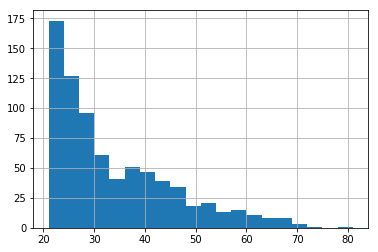

In [8]:
diabetes['Age'].hist(bins=20)

In [9]:
tf_num_cols

[_NumericColumn(key='Number_pregnant', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 _NumericColumn(key='Glucose_concentration', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 _NumericColumn(key='Blood_pressure', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 _NumericColumn(key='Triceps', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 _NumericColumn(key='Insulin', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 _NumericColumn(key='BMI', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 _NumericColumn(key='Pedigree', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 _NumericColumn(key='Age', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None)]

In [10]:
age_bucket = tf.feature_column.bucketized_column(tf_num_cols[-1], boundaries=[20,30,40,50,60,70,80])

Combine a list of all feature columns to use in the TensorFlow model.

In [11]:
tf_feat_cols = tf_num_cols[:-1] + tf_cat_cols + [age_bucket]
tf_feat_cols

[_NumericColumn(key='Number_pregnant', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 _NumericColumn(key='Glucose_concentration', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 _NumericColumn(key='Blood_pressure', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 _NumericColumn(key='Triceps', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 _NumericColumn(key='Insulin', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 _NumericColumn(key='BMI', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 _NumericColumn(key='Pedigree', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 _VocabularyListCategoricalColumn(key='Group', vocabulary_list=('B', 'C', 'A', 'D'), dtype=tf.string, default_value=-1, num_oov_buckets=0),
 _BucketizedColumn(source_column=_NumericColumn(key='Age', shape=(1,), default_value=None, dtype=tf.float32, normalizer_

#### Train-test split

In [12]:
x_data = diabetes.drop('Class', axis=1)
x_data.head()

,Number_pregnant,Glucose_concentration,Blood_pressure,Triceps,Insulin,BMI,Pedigree,Age,Group
0,0.352941,0.743719,0.590164,0.353535,0.000000,0.500745,0.234415,50,B
1,0.058824,0.427136,0.540984,0.292929,0.000000,0.396423,0.116567,31,C
2,0.470588,0.919598,0.524590,0.000000,0.000000,0.347243,0.253629,32,B
3,0.058824,0.447236,0.540984,0.232323,0.111111,0.418778,0.038002,21,B
4,0.000000,0.688442,0.327869,0.353535,0.198582,0.642325,0.943638,33,C


In [13]:
y_labels = diabetes['Class']
y_labels.head()

0    1
1    0
2    1
3    0
4    1
Name: Class, dtype: int64

In [14]:
from sklearn.model_selection import train_test_split

In [15]:
X_train, X_test, y_train, y_test = train_test_split(x_data, y_labels, test_size=0.3, random_state=101)

#### Train TensorFlow model  
- Define ***Input Functions***, which is kinda' a connector from your dataset (in forms of either `numpy` arrays or `Pandas` dataframes). 

In [16]:
input_func = tf.estimator.inputs.pandas_input_fn(x=X_train, y=y_train,
                                                batch_size=10,
                                                num_epochs=1000,
                                                shuffle=True)

- Create a `LinearClassifier` model
- Specify an input function to connect it to our Pandas dataframe
- Train the model

In [17]:
model = tf.estimator.LinearClassifier(feature_columns=tf_feat_cols,
                                     n_classes=2)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_log_step_count_steps': 100, '_keep_checkpoint_every_n_hours': 10000, '_model_dir': '/var/folders/n_/yc8w5lvd0939ndnjzj5wm8mr0000gn/T/tmpp5ij63ea', '_tf_random_seed': 1, '_save_summary_steps': 100, '_keep_checkpoint_max': 5, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None}


In [18]:
model.train(input_fn=input_func, steps=1000)

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into /var/folders/n_/yc8w5lvd0939ndnjzj5wm8mr0000gn/T/tmpp5ij63ea/model.ckpt.
INFO:tensorflow:step = 1, loss = 6.93147
INFO:tensorflow:global_step/sec: 332.961
INFO:tensorflow:step = 101, loss = 4.61249 (0.301 sec)
INFO:tensorflow:global_step/sec: 367.907
INFO:tensorflow:step = 201, loss = 6.75567 (0.272 sec)
INFO:tensorflow:global_step/sec: 358.042
INFO:tensorflow:step = 301, loss = 5.16083 (0.279 sec)
INFO:tensorflow:global_step/sec: 366.119
INFO:tensorflow:step = 401, loss = 3.07755 (0.273 sec)
INFO:tensorflow:global_step/sec: 361.323
INFO:tensorflow:step = 501, loss = 7.54619 (0.277 sec)
INFO:tensorflow:global_step/sec: 381.745
INFO:tensorflow:step = 601, loss = 5.53635 (0.262 sec)
INFO:tensorflow:global_step/sec: 386.114
INFO:tensorflow:step = 701, loss = 3.65225 (0.259 sec)
INFO:tensorflow:global_step/sec: 408.067
INFO:tensorflow:step = 801, loss = 5.90439 (0.245 sec)
INFO:tensorflow:global_step/

- Make an input function for `X_test` and `y_test`
- Evaluate the model with `X_test` and `y_test`

In [19]:
eval_input_func = tf.estimator.inputs.pandas_input_fn(x=X_test, y=y_test,
                                                     batch_size=10,
                                                     num_epochs=1,
                                                     shuffle=False)

In [20]:
results = model.evaluate(eval_input_func)
results

INFO:tensorflow:Starting evaluation at 2017-12-14-10:16:25
INFO:tensorflow:Restoring parameters from /var/folders/n_/yc8w5lvd0939ndnjzj5wm8mr0000gn/T/tmpp5ij63ea/model.ckpt-1000
INFO:tensorflow:Finished evaluation at 2017-12-14-10:16:26
INFO:tensorflow:Saving dict for global step 1000: accuracy = 0.748918, accuracy_baseline = 0.649351, auc = 0.80251, auc_precision_recall = 0.650048, average_loss = 0.523618, global_step = 1000, label/mean = 0.350649, loss = 5.03982, prediction/mean = 0.365759


{'accuracy': 0.74891776,
 'accuracy_baseline': 0.64935064,
 'auc': 0.80251032,
 'auc_precision_recall': 0.65004754,
 'average_loss': 0.52361768,
 'global_step': 1000,
 'label/mean': 0.35064936,
 'loss': 5.0398202,
 'prediction/mean': 0.36575893}

- Predict with the model

In [21]:
pred_input_func = tf.estimator.inputs.pandas_input_fn(x=X_test,
                                                     batch_size=10,
                                                     num_epochs=1,
                                                     shuffle=False)

In [22]:
predictions = model.predict(pred_input_func)
predictions

<generator object Estimator.predict at 0x11d9142b0>

`model.predict()` returns a generator, cast into list and see first few predicitons.

In [23]:
list(predictions)[:5]

INFO:tensorflow:Restoring parameters from /var/folders/n_/yc8w5lvd0939ndnjzj5wm8mr0000gn/T/tmpp5ij63ea/model.ckpt-1000


[{'class_ids': array([1]),
  'classes': array([b'1'], dtype=object),
  'logistic': array([ 0.53773355], dtype=float32),
  'logits': array([ 0.15122175], dtype=float32),
  'probabilities': array([ 0.46226645,  0.53773355], dtype=float32)},
 {'class_ids': array([1]),
  'classes': array([b'1'], dtype=object),
  'logistic': array([ 0.63058066], dtype=float32),
  'logits': array([ 0.53470874], dtype=float32),
  'probabilities': array([ 0.36941931,  0.63058066], dtype=float32)},
 {'class_ids': array([0]),
  'classes': array([b'0'], dtype=object),
  'logistic': array([ 0.37205687], dtype=float32),
  'logits': array([-0.52340287], dtype=float32),
  'probabilities': array([ 0.6279431 ,  0.37205687], dtype=float32)},
 {'class_ids': array([0]),
  'classes': array([b'0'], dtype=object),
  'logistic': array([ 0.32158014], dtype=float32),
  'logits': array([-0.74651968], dtype=float32),
  'probabilities': array([ 0.67841989,  0.32158011], dtype=float32)},
 {'class_ids': array([0]),
  'classes': arra

## TensorFlow Dense Neural Network (DNN) Classifier

In [24]:
dnn_model = tf.estimator.DNNClassifier(hidden_units=[10, 10, 10],   # 3 hiden layers, 10 neurons each
                                       feature_columns=tf_feat_cols,
                                       n_classes=2
                                      )    

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_log_step_count_steps': 100, '_keep_checkpoint_every_n_hours': 10000, '_model_dir': '/var/folders/n_/yc8w5lvd0939ndnjzj5wm8mr0000gn/T/tmpkf9ssi_4', '_tf_random_seed': 1, '_save_summary_steps': 100, '_keep_checkpoint_max': 5, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None}


This line below below will give you trouble, because of the categorical columns. 

In [25]:
dnn_model.train(input_fn=input_func, steps=1000)

ValueError: Items of feature_columns must be a _DenseColumn. You can wrap a categorical column with an embedding_column or indicator_column. Given: _VocabularyListCategoricalColumn(key='Group', vocabulary_list=('B', 'C', 'A', 'D'), dtype=tf.string, default_value=-1, num_oov_buckets=0)

In [26]:
embeded_group_col = tf.feature_column.embedding_column(tf_cat_cols[0], dimension=4)

In [29]:
dnn_feat_cols = tf_num_cols[:-1] + [embeded_group_col] + [age_bucket]
dnn_feat_cols

[_NumericColumn(key='Number_pregnant', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 _NumericColumn(key='Glucose_concentration', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 _NumericColumn(key='Blood_pressure', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 _NumericColumn(key='Triceps', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 _NumericColumn(key='Insulin', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 _NumericColumn(key='BMI', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 _NumericColumn(key='Pedigree', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 _EmbeddingColumn(categorical_column=_VocabularyListCategoricalColumn(key='Group', vocabulary_list=('B', 'C', 'A', 'D'), dtype=tf.string, default_value=-1, num_oov_buckets=0), dimension=4, combiner='mean', initializer=<tensorflow.python.ops.init_ops.TruncatedN

In [30]:
input_func = tf.estimator.inputs.pandas_input_fn(X_train, y_train, batch_size=10, num_epochs=1000, shuffle=True)

In [31]:
dnn_model = tf.estimator.DNNClassifier(hidden_units=[10,10,10], feature_columns=dnn_feat_cols, n_classes=2)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_log_step_count_steps': 100, '_keep_checkpoint_every_n_hours': 10000, '_model_dir': '/var/folders/n_/yc8w5lvd0939ndnjzj5wm8mr0000gn/T/tmpmf4ewukn', '_tf_random_seed': 1, '_save_summary_steps': 100, '_keep_checkpoint_max': 5, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None}


In [32]:
dnn_model.train(input_fn=input_func, steps=1000)

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into /var/folders/n_/yc8w5lvd0939ndnjzj5wm8mr0000gn/T/tmpmf4ewukn/model.ckpt.
INFO:tensorflow:step = 1, loss = 9.2026
INFO:tensorflow:global_step/sec: 386.367
INFO:tensorflow:step = 101, loss = 5.35473 (0.260 sec)
INFO:tensorflow:global_step/sec: 397.257
INFO:tensorflow:step = 201, loss = 4.66667 (0.252 sec)
INFO:tensorflow:global_step/sec: 405.826
INFO:tensorflow:step = 301, loss = 3.59774 (0.246 sec)
INFO:tensorflow:global_step/sec: 375.535
INFO:tensorflow:step = 401, loss = 5.77972 (0.269 sec)
INFO:tensorflow:global_step/sec: 461.331
INFO:tensorflow:step = 501, loss = 4.39422 (0.217 sec)
INFO:tensorflow:global_step/sec: 343.559
INFO:tensorflow:step = 601, loss = 4.25365 (0.291 sec)
INFO:tensorflow:global_step/sec: 364.352
INFO:tensorflow:step = 701, loss = 4.80026 (0.275 sec)
INFO:tensorflow:global_step/sec: 401.544
INFO:tensorflow:step = 801, loss = 5.09506 (0.249 sec)
INFO:tensorflow:global_step/s

In [33]:
eval_input_func = tf.estimator.inputs.pandas_input_fn(x=X_test, y=y_test, batch_size=10, num_epochs=1, shuffle=False)

In [34]:
dnn_model.evaluate(eval_input_func)

INFO:tensorflow:Starting evaluation at 2017-12-14-10:29:11
INFO:tensorflow:Restoring parameters from /var/folders/n_/yc8w5lvd0939ndnjzj5wm8mr0000gn/T/tmpmf4ewukn/model.ckpt-1000
INFO:tensorflow:Finished evaluation at 2017-12-14-10:29:12
INFO:tensorflow:Saving dict for global step 1000: accuracy = 0.761905, accuracy_baseline = 0.649351, auc = 0.832017, auc_precision_recall = 0.676358, average_loss = 0.488296, global_step = 1000, label/mean = 0.350649, loss = 4.69985, prediction/mean = 0.384024


{'accuracy': 0.76190478,
 'accuracy_baseline': 0.64935064,
 'auc': 0.83201653,
 'auc_precision_recall': 0.67635846,
 'average_loss': 0.48829594,
 'global_step': 1000,
 'label/mean': 0.35064936,
 'loss': 4.6998487,
 'prediction/mean': 0.38402438}